In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import re
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
path = 'imdb.csv'
df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [5]:
print('POSITIVE REVIEW EXAMPLES:\n')
for review in df[df.sentiment == 1].review[0:5]:
    print(review[:200] + '...\n')

print('NEGATIVE REVIEW EXAMPLES:\n')
for review in df[df.sentiment == 0].review[0:5]:
    print(review[:200] + '...\n')

POSITIVE REVIEW EXAMPLES:

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is wi...

Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, p...

Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it's not preachy or boring. It just never ge

In [6]:
df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 65.7 MB


The size of the dataset is 77.0 MB.

# EDA

In [7]:
df['review'] = df['review'].str.replace(r'<br\s*/?>', ' ', flags=re.IGNORECASE, regex=True)


In [8]:
df.sentiment.value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [9]:
review_lengths = []

for review in df.review:
    review_lengths.append(len(review))

print(f'Mean review length: ~{int(np.mean(review_lengths))} characters')


Mean review length: ~1289 characters


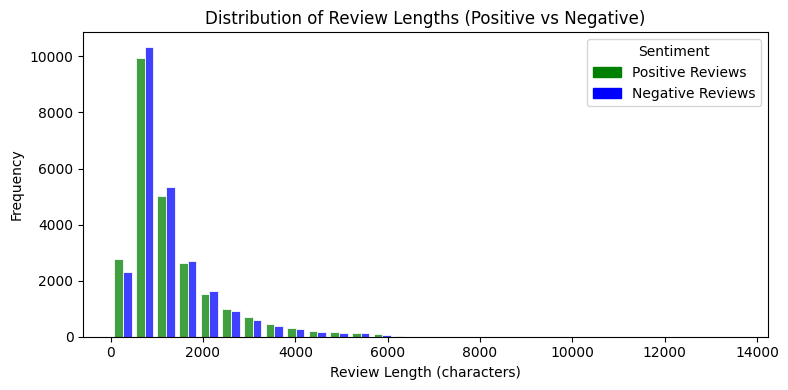

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

df['sentiment_label'] = df['sentiment'].map({1: 'Positive Reviews', 0: 'Negative Reviews'})
df['review_length'] = df['review'].str.len()

min_len = df['review_length'].min()
max_len = df['review_length'].max()
bins    = np.linspace(min_len, max_len, 30)

plt.figure(figsize=(8,4))
ax = sns.histplot(
    data=df,
    x='review_length',
    hue='sentiment_label',
    bins=bins,
    multiple='dodge',
    shrink=0.8,
    palette={'Positive Reviews':'green','Negative Reviews':'blue'},
    legend=False,
    edgecolor='white'
)

pos_patch = mpatches.Patch(color='green', label='Positive Reviews')
neg_patch = mpatches.Patch(color='blue',  label='Negative Reviews')
ax.legend(handles=[pos_patch, neg_patch], title='Sentiment', loc='upper right')

ax.set_title('Distribution of Review Lengths (Positive vs Negative)')
ax.set_xlabel('Review Length (characters)')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


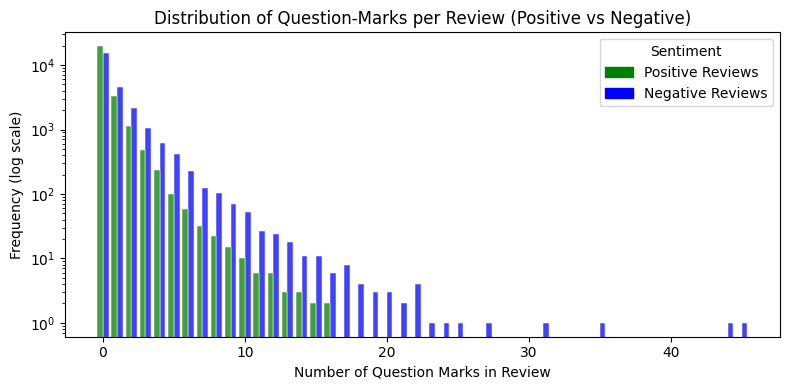

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# map sentiment to labels
df['sentiment_label'] = df['sentiment'].map({1: 'Positive Reviews', 0: 'Negative Reviews'})

# count question-marks per review
df['num_qmarks'] = df['review'].str.count(r'\?')

# get min/max for consistent binning (integer bins)
min_q = df['num_qmarks'].min()
max_q = df['num_qmarks'].max()
# bins from min to max, +1 so the last count is included
bins = np.arange(min_q, max_q + 2) - 0.5

plt.figure(figsize=(8, 4))
ax = sns.histplot(
    data=df,
    x='num_qmarks',
    hue='sentiment_label',
    bins=bins,
    multiple='dodge',
    shrink=0.8,
    palette={'Positive Reviews':'green', 'Negative Reviews':'blue'},
    legend=False,
    edgecolor='white'
)

# add legend manually
pos_patch = mpatches.Patch(color='green', label='Positive Reviews')
neg_patch = mpatches.Patch(color='blue',  label='Negative Reviews')
ax.legend(handles=[pos_patch, neg_patch], title='Sentiment', loc='upper right')

# log-scale on y-axis
ax.set_yscale('log')

# labels & title
ax.set_title('Distribution of Question-Marks per Review (Positive vs Negative)')
ax.set_xlabel('Number of Question Marks in Review')
ax.set_ylabel('Frequency (log scale)')

plt.tight_layout()
plt.show()


In [12]:
all_reviews = df['review']

vectorizer_all = CountVectorizer(stop_words='english')
X_all = vectorizer_all.fit_transform(all_reviews)

word_counts_all = X_all.sum(axis=0).A1
vocab_all = vectorizer_all.get_feature_names_out()
word_freq_all = pd.Series(word_counts_all, index=vocab_all).sort_values(ascending=False).head(20)


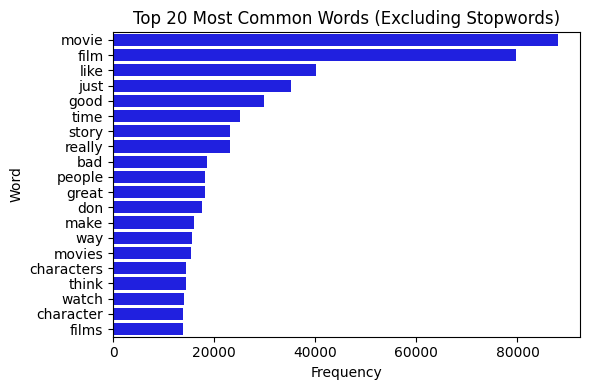

In [23]:
plt.figure(figsize=(6, 4))
sns.barplot(x=word_freq_all.values, y=word_freq_all.index, color='blue')
plt.title("Top 20 Most Common Words (Excluding Stopwords)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

In [14]:
positive_reviews = df[df['sentiment'] == 1]['review']
negative_reviews = df[df['sentiment'] == 0]['review']

vectorizer = CountVectorizer(stop_words='english')
X_pos = vectorizer.fit_transform(positive_reviews)
X_neg = CountVectorizer(stop_words='english', vocabulary=vectorizer.vocabulary_).fit_transform(negative_reviews)

word_counts_pos = X_pos.sum(axis=0).A1
word_counts_neg = X_neg.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()

pos_freq = pd.Series(word_counts_pos, index=vocab).sort_values(ascending=False).head(500)
neg_freq = pd.Series(word_counts_neg, index=vocab).sort_values(ascending=False).head(500)

pos_unique = pos_freq[~pos_freq.index.isin(neg_freq.index)]
neg_unique = neg_freq[~neg_freq.index.isin(pos_freq.index)]

print("Top distinctive words in positive reviews:\n")
print(pos_unique[:15])

print("\nTop distinctive words in negative reviews:\n")
print(neg_unique[:15])


Top distinctive words in positive reviews:

excellent     3359
wonderful     2668
perfect       2434
loved         2239
amazing       2004
brilliant     1874
today         1867
favorite      1843
heart         1779
enjoyed       1719
highly        1701
strong        1511
hilarious     1408
experience    1393
simple        1368
dtype: int64

Top distinctive words in negative reviews:

worst            4888
awful            3143
poor             3027
boring           2997
stupid           2968
terrible         2902
waste            2611
worse            2479
supposed         2248
oh               2228
horrible         2183
unfortunately    1799
crap             1784
decent           1626
hour             1575
dtype: int64


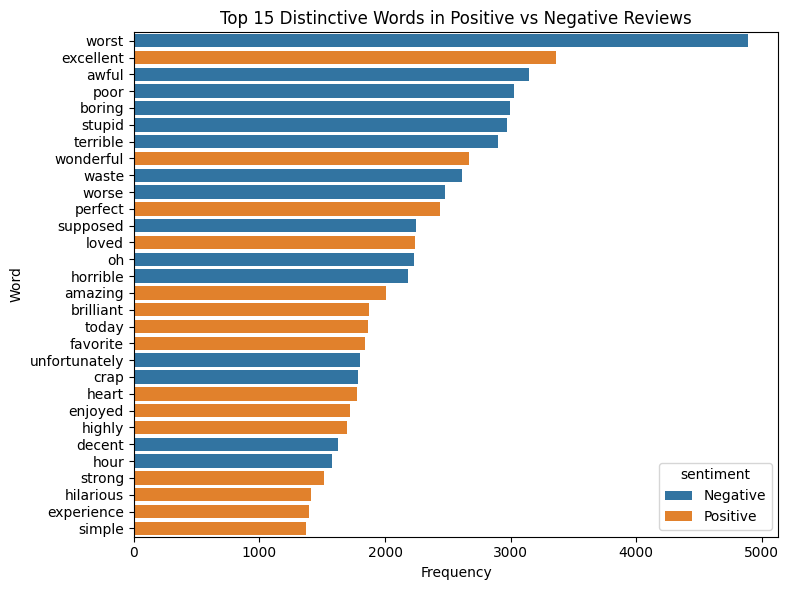

In [15]:
# Get top 15 distinctive words from each
top_pos_unique = pos_unique.head(15)
top_neg_unique = neg_unique.head(15)

# Create a DataFrame for plotting
distinctive_df = pd.concat([
    pd.DataFrame({'word': top_pos_unique.index, 'count': top_pos_unique.values, 'sentiment': 'Positive'}),
    pd.DataFrame({'word': top_neg_unique.index, 'count': top_neg_unique.values, 'sentiment': 'Negative'})
])

# Sort for better plotting
distinctive_df = distinctive_df.sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=distinctive_df, x='count', y='word', hue='sentiment', dodge=False)
plt.title("Top 15 Distinctive Words in Positive vs Negative Reviews")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


# Baseline model: Bag of Words / Naive Bayes

In [16]:
X = df['review']
y = df['sentiment']


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_bow, y_train)

y_pred = model.predict(X_test_bow)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8442

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      5035
           1       0.87      0.81      0.84      4965

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



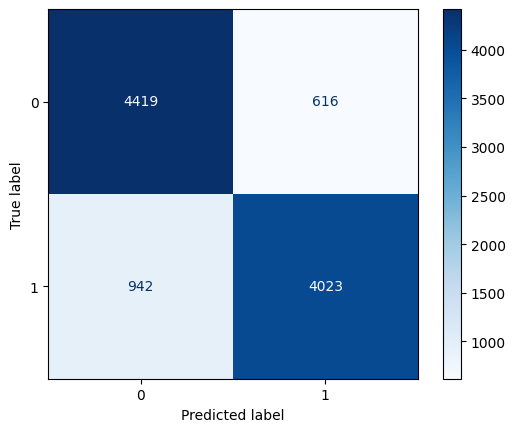

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
